In [ ]:
import lusid
import numpy as np
import lusid_sample_data as import_data
from lusidtools.jupyter_tools import toggle_code

"""Interest Rate Swap Valuation

Demonstrates pricing of an Interest Rate Swap based on a user defined Instrument.

Attributes
----------
instruments
valuation
lifecycle events
market data store
results store
quotes
"""

toggle_code("Hide docstring")

In [ ]:
# Import LUSID libraries
import lusid as lu
import lusid.models as lm

from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidjam.refreshing_token import RefreshingToken

from utilities.instrument_utils import (
    add_utc_to_df,
    create_property,
)

from utilities.formatting_tools import (
    cash_flow_response_to_df,
)

# Import Libraries
from datetime import datetime, timedelta
from IPython.display import display_html
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json
import os

# Settings and utility functions to display objects and responses more clearly.
pd.set_option('float_format', '{:,.4f}'.format)

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

api_factory = lu.utilities.ApiClientFactory(
        token=RefreshingToken(),
        api_secrets_filename = secrets_path,
        app_name="LusidJupyterNotebook")

print ('LUSID Environment Initialised')
print ('LUSID SDK Version: ', api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version)


LUSID Environment Initialised
LUSID SDK Version:  0.6.10435.0


In [ ]:
# Initiate the LUSID APIs required for the notebook
instruments_api = api_factory.build(lu.api.InstrumentsApi)
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lu.api.PortfoliosApi)
quotes_api = api_factory.build(lu.api.QuotesApi)
complex_market_data_api = api_factory.build(lu.api.ComplexMarketDataApi)
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
aggregation_api = api_factory.build(lu.AggregationApi)
structured_result_data_api = api_factory.build(lu.api.StructuredResultDataApi)

## Interest Rate Swap Valuation 

This notebook illustrates the construction of an interest rate swap using the LUSID instrument definition. With the instrument setup, the notebook will cover valuations and cash flow projections/queries as well as life cycle event handling and querying. We also demonstrate how to group multiple transactions using a sub-holding key to keep them linked to a particular deal, for example.

For valuations, we will be demonstrating the following LUSID models:

- _Discounting_, which depends on a set of user-defined curves to discount each cash flows and project resets.
- _Constant Time Value of Money_, which values cash flows and accrued interest with zero interest discounting.

These models will be applied to a portfolio with two interest rate swaps:

- One vanilla interest rate swap with the following parameters:
    -  Coupon Rate: 2%
    -  Spread: 0bp
    -  Start Date: 01/10/2021
    -  Maturity: ~10Y (front stub)
    -  Currency: EUR
    -  Payment Frequency: 6M
    -  Index: ESTRON 1D
    -  Notional: 10 million
    -  Side: Receive Fixed
- One cross currency basis swap with the following parameters:
    -  Start Date: 03/10/2022
    -  Maturity: 02/10/2026
    -  Pay/Receive Frequency: 3M
    -  Pay Currency: GBP
    -  Pay Index: SONIA 1D
    -  Receive Currency: USD
    -  Receive Index: SOFR 1D
    -  Notional: 2 million

In the case of floating legs, LUSID supports various accrual calculations using look-back averages and compounding of the overnight rate.

### Table of contents
1. [Portfolio Creation](#1.-Portfolio-Creation)
2. [Instrument Creation](#2.-Instrument-Creation)
  * [2.1 Vanilla Interest Rate Swap Definition](#2.1-Vanilla-Interest-Rate-Swap-Definition)
  * [2.2 Cross Currency Swap Definition](#2.2-Cross-Currency-Swap-Instrument-Definition)
3. [Upsert Transactions](#3.-Upsert-Transactions)
4. [Upsert Market Data](#4.-Upsert-Market-Data)
5. [Creating Valuation Recipes](#5.-Creating-Valuation-Recipes)
  * [5.1 Valuation with Discounting](#5.1-Valuation-with-Discounting)
  * [5.2 Valuation with Constant Time Value of Money](#5.2-Valuation-with-Constant-Time-Value-of-Money)
6. [Instrument Valuation and Cash Flows](#6.-Instrument-Valuation-and-Cash-Flows)
  * [6.1 Querying Valuation Results](#6.1-Querying-Valuation-Results)
  * [6.2 Querying Cash Flows](#6.2-Querying-Cash-Flows)
  * [6.3 Overriding Cash Flows](#6.3-Overriding-Cash-Flows)
  * [6.4 Querying Curves](#6.4-Querying-Curves)
7. [Instrument Lifecycle](#7.-Instrument-Lifecycle)
  * [7.1 Configuring Transactions](#7.1-Configuring-Transactions)
  * [7.2 Cash Handling on Payment Date](#7.2-Cash-Handling-on-Payment-Date)
8. [P&L Reporting](#8.-P&L-Reporting)


## 1. Portfolio Creation

We begin by creating a portfolio that will contain the Interest Rate Swap instruments that we will be looking to price. We will be grouping the deals using a [sub-holding key](https://support.lusid.com/knowledgebase/article/KA-01879/en-us) to keep them with a common transaction tag for joining in aggregation. This common transaction tag can be associated with a particular deal, for example.

We also need to set the scope for the instruments to be created and specify the date being used for the valuation.

In [ ]:
# Set the valuation date
effective_at = datetime(2022, 11, 30, 0, 0, tzinfo=pytz.utc)

# Set the scope of the instruments (optional/nullable)
instrument_scope = "TestSwapNotebook"

In [ ]:
# Setup scope and code for the portfolio
portfolio_scope = "Finbourne-Examples"
portfolio_code = "Interest-Rate-Swap-Notebook"

# Set sub-holding key
strategy_code = "Strategy"
create_property(
    api_factory=api_factory,
    domain="Transaction",
    scope=portfolio_scope,
    code=strategy_code,
    name=strategy_code,
    data_type="string"
)
strategy_key = f"Transaction/{portfolio_scope}/{strategy_code}"
sub_holding_keys = [strategy_key]

# Set transaction type scope
transaction_type_scope = import_data.create_scope_id()

Property Transaction/Finbourne-Examples/Strategy already exists


In [ ]:
# Create portfolio
try:
    transaction_portfolios_api.create_portfolio(
        scope=portfolio_scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            sub_holding_keys=sub_holding_keys,
            instrument_scopes=[instrument_scope]
        ),
    )
    print(f"Portfolio for {portfolio_scope} | {portfolio_code} created successfully.")

except lu.ApiException as e:
    print(json.loads(e.body)["title"])


Could not create a portfolio with id 'Interest-Rate-Swap-Notebook' because it already exists in scope 'Finbourne-Examples'.


And, finally, we define a helper function that will be useful to add the instruments to our portfolio:

In [ ]:
# Define helper tools
def get_instrument(
        identifier: str,
        identifier_type: str="ClientInternal",
        scope: str=None,
   )-> lm.Instrument:
    return instruments_api.get_instrument(
        identifier_type=identifier_type,
        identifier=identifier,
        scope=scope
    )

## 2. Instrument Creation

### 2.1 Vanilla Interest Rate Swap Definition

We can begin by setting the contract details of the swap which we will feed into LUSID. In this case we will be looking at a 10y EUR-OIS swap with a short front stub. Notice that the market data identifiers (for example, reference_index = "ESTRON") are arbitrary strings that we are creating to link to the market data that we will upsert later. Therefore, we need to keep track of these ids being created now as they will need to be the same as the ones we will use at the market data upserting stage later in this notebook example.

Also notice the parameter `stub_type` - this parameter refers to the method that LUSID will use to adjust dates from auto-generated schedules if the time elapsed between the start date and the end date is not an exact multiple of the payment frequency. The `ShortFront` choice means that the payment schedules are generated from the maturity date with the payment frequency being added backwards and if the interval between the start date and the first payment date turns out to be shorter than the payment frequency, this will not be adjusted. Depending on the input parameters, this can generate a very short interval between the start date and the first payment date (i.e. a short "stub"). If adjustment is required to ensure that the interval between all payment dates is no shorter than the payment frequency (possibly resulting in a first payment happening longer than the payment frequency), then the `stub_type` should be specified as `LongFront`.


In [ ]:
# Set details for the vanilla swap
start_date_vanilla = datetime(2021, 10, 1, 0, 0, tzinfo=pytz.utc)
end_date = datetime(2031, 10, 1, 0, 0, tzinfo=pytz.utc)
instrument_ccy = "EUR"
payment_frequency = "6M"
index_tenor = "1D"
reference_index = "ESTRON"
notional = 10000000
cpn = 0.02
spread = 0
day_count_convention = "Actual360"
stub_type = "ShortFront"
name = "EUROIS.REC.10Y"
instrument_identifier = "EUR-OIS-SWAP001"



Within LUSID, an interest rate swap will need to be defined by first creating each leg, which will depend on a [_flow convention_](https://www.lusid.com/docs/api#operation/UpsertFlowConventions) that sets the payment details. As shown below, this is where we determine details such as the payment frequency and day count conventions.

Below is the creation of the fixed leg:

In [ ]:
# Create the flow conventions for the swap
swap_flows = lm.FlowConventions(
    currency=instrument_ccy,
    payment_frequency=payment_frequency,
    day_count_convention=day_count_convention,
    roll_convention="ModifiedFollowing",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=0,
    reset_days=0
)

# Create the fixed leg details
fixed_leg_definition = lm.LegDefinition(
    rate_or_spread=cpn,
    pay_receive="Receive",
    conventions=swap_flows,
    stub_type=stub_type,
    notional_exchange_type="None"
)

# Persist the fixed leg
fixed_leg = lm.FixedLeg(
    start_date=start_date_vanilla,
    maturity_date=end_date,
    notional=notional,
    leg_definition=fixed_leg_definition,
    instrument_type="FixedLeg"
)

For the floating leg, we will also use a model that sets the [_index convention_](https://www.lusid.com/docs/api#operation/UpsertIndexConvention), which is where we will specify details relating to the ESTRON reference index. The details in the index convention will later be used to tie the instrument back to market data elements such as ESTRON fixings and the related forward curve.

In [ ]:
# Create the index convention for the floating leg
floating_idx_convention = lm.IndexConvention(
        currency=instrument_ccy,
        payment_tenor=index_tenor,
        fixing_reference=reference_index,
        publication_day_lag=0,
        day_count_convention=day_count_convention,
        index_name=reference_index
    )

# Create the floating leg details
floating_leg_definition = lm.LegDefinition(
    rate_or_spread = spread,
    index_convention = floating_idx_convention,
    pay_receive = "Pay",
    conventions = swap_flows,
    stub_type=stub_type,
    notional_exchange_type="None",
    reset_convention="InArrears",
    compounding=lm.Compounding(
        compounding_method="Compounded",
        reset_frequency="1D",
        spread_compounding_method="SpreadExclusive"
    )
)

# Persist floating leg
floating_leg = lm.FloatingLeg(
    start_date=start_date_vanilla,
    maturity_date=end_date,
    notional=notional,
    leg_definition=floating_leg_definition,
    instrument_type="FloatingLeg"
)

Using the above definitions we can move to building the swap and its component legs.

In [ ]:
# Store legs in a list
irs_legs = [
    fixed_leg,
    floating_leg
]

# Create the swap
instrument_definition = lm.InterestRateSwap(
    start_date=start_date_vanilla,
    maturity_date=end_date,
    legs=irs_legs,
    instrument_type="InterestRateSwap"
)


# Create instrument definition
swap_instrument_definition = lm.InstrumentDefinition(
    name=name,
    identifiers={"ClientInternal": lm.InstrumentIdValue(value=instrument_identifier)},
    definition=instrument_definition
)
upsert_request = {instrument_identifier: swap_instrument_definition}

# Upsert instrument to LUSID
response = instruments_api.upsert_instruments(
    request_body=upsert_request,
    scope=instrument_scope
)

if len(response.failed) == 0:
    print(f"Instrument {swap_instrument_definition.name} was successfully upserted into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)

Instrument EUROIS.REC.10Y was successfully upserted into LUSID


In [ ]:
# Get and store the instrument response
response = get_instrument(identifier=instrument_identifier, scope=instrument_scope)

# Store LUID
vanilla_luid = response.lusid_instrument_id

# Store response leg definitions as dataframes
vanilla_flt_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[1])
vanilla_fix_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[0])

For auditing purposes, we may want to display the data from the legs. The code below shows how to do it:

In [ ]:
# Display the leg dataframes
df1_styler = vanilla_flt_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Floating Leg')
df2_styler = vanilla_fix_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Fixed Leg')
display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

,response_values
start_date,2021-10-01 00:00:00+00:00
maturity_date,2031-10-01 00:00:00+00:00
leg_definition.convention_name,None
leg_definition.conventions.currency,EUR
leg_definition.conventions.payment_frequency,6M
leg_definition.conventions.day_count_convention,Actual360
leg_definition.conventions.roll_convention,ModifiedFollowing
leg_definition.conventions.payment_calendars,[]
leg_definition.conventions.reset_calendars,[]
leg_definition.conventions.settle_days,0


### 2.2 Cross Currency Swap Instrument Definition

The code below demonstrates how to create a cross currency swap. This instrument will be subsequently added to the portfolio together with the vanilla swap previously created. The instrument will be created with a `LongFront` choice of `stub_type` just for demonstration purposes. Most of the steps are similar to the steps followed for the creation of the vanilla interest rate swap; however, the swaps of this example have been deliberatly constructed with input parameters different than the ones from the vanilla swaps in order to demonstrate a larger subset of the instrument configuration choices available.

There are several other possible choices of day count convention, stub types, roll convention, etc. More details can be found in the [_LUSID knowledge base_](https://support.lusid.com/knowledgebase/).

In [ ]:
# Set details for the cross currency swap that are common across both legs
start_date_xccy = datetime(2022, 10, 3, 0, 0, tzinfo=pytz.utc)
end_date_xccy = datetime(2026, 10, 2, 0, 0, tzinfo=pytz.utc)
pay_ccy = "GBP"
receive_ccy = "USD"
pay_receive_frequency = "3M"
index_tenor = "1D"
pay_index = "SONIA1D"
receive_index = "SOFR1D"
notional = 2000000
spread = 0
day_count_convention = "Bus252"
stub_type = "LongFront"
name = "GBPUSD.XCCY.4Y"
xccy_instrument_identifier = "GBP-USD-XCCYSWAP001"

In [ ]:
# Create the GBP leg details
gbp_flows = lm.FlowConventions(
    currency=pay_ccy,
    payment_frequency=payment_frequency,
    day_count_convention=day_count_convention,
    roll_convention="ModifiedFollowing",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=0,
    reset_days=0
)

gbp_idx_convention = lm.IndexConvention(
        currency=pay_ccy,
        payment_tenor=index_tenor,
        fixing_reference=pay_index,
        publication_day_lag=0,
        day_count_convention=day_count_convention,
        index_name=pay_index
    )

gbp_leg_definition = lm.LegDefinition(
    index_convention = gbp_idx_convention,
    rate_or_spread = spread,
    pay_receive="Pay",
    conventions=gbp_flows,
    stub_type=stub_type,
    notional_exchange_type="None",
    reset_convention="InArrears",
    compounding=lm.Compounding(
        compounding_method="Compounded",
        reset_frequency="1D",
        spread_compounding_method="SpreadExclusive"
    )
)

# Persist the GBP leg
gbp_leg = lm.FloatingLeg(
    start_date=start_date_xccy,
    maturity_date=end_date_xccy,
    notional=notional,
    leg_definition=gbp_leg_definition,
    instrument_type="FloatingLeg"
)


In [ ]:
# Create the USD leg details
usd_flows = lm.FlowConventions(
    currency=receive_ccy,
    payment_frequency=payment_frequency,
    day_count_convention=day_count_convention,
    roll_convention="ModifiedFollowing",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=0,
    reset_days=0
)

usd_idx_convention = lm.IndexConvention(
        currency=receive_ccy,
        payment_tenor=index_tenor,
        fixing_reference=receive_index,
        publication_day_lag=0,
        day_count_convention=day_count_convention,
        index_name=receive_index
    )

usd_leg_definition = lm.LegDefinition(
    rate_or_spread = spread,
    pay_receive="Receive",
    conventions=usd_flows,
    index_convention = usd_idx_convention,
    stub_type=stub_type,
    notional_exchange_type="None",
    reset_convention="InArrears",
    compounding=lm.Compounding(
        compounding_method="Compounded",
        reset_frequency="1D",
        spread_compounding_method="SpreadExclusive"
    )
)

# Persist the USD leg
usd_leg = lm.FloatingLeg(
    start_date=start_date_xccy,
    maturity_date=end_date_xccy,
    notional=notional,
    leg_definition=usd_leg_definition,
    instrument_type="FloatingLeg"
)

In [ ]:
# Store legs in a list
xccy_irs_legs = [
    gbp_leg,
    usd_leg
]

# Create the swap
instrument_definition = lm.InterestRateSwap(
    start_date=start_date_xccy,
    maturity_date=end_date_xccy,
    legs=xccy_irs_legs,
    instrument_type="InterestRateSwap"
)


# Create instrument definition
xccy_swap_instrument_definition = lm.InstrumentDefinition(
    name=name,
    identifiers={"ClientInternal": lm.InstrumentIdValue(value=xccy_instrument_identifier)},
    definition=instrument_definition
)
xccy_upsert_request = {xccy_instrument_identifier: xccy_swap_instrument_definition}

# Upsert instrument to LUSID
response = instruments_api.upsert_instruments(
    request_body=xccy_upsert_request,
    scope=instrument_scope
)

if len(response.failed) == 0:
    print(f"Instrument {xccy_swap_instrument_definition.name} was successfully upserted into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)
    
# Get and store the instrument response
response = get_instrument(identifier=xccy_instrument_identifier, scope=instrument_scope)

# Store LUID
xccy_luid = response.lusid_instrument_id

# Store response leg definitions as dataframes
xccy_flt_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[1])
xccy_fix_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[0])


Instrument GBPUSD.XCCY.4Y was successfully upserted into LUSID


Also, only for auditing purposes, below we display the data from the cross currency swap legs:

In [ ]:
# Display the leg dataframes
xccy1_styler = xccy_flt_leg_df.style.set_table_attributes("style='display:inline'").set_caption('GBP Leg')
xccy2_styler = xccy_fix_leg_df.style.set_table_attributes("style='display:inline'").set_caption('USD Leg')
display_html(xccy1_styler._repr_html_() + xccy2_styler._repr_html_(), raw=True)

,response_values
start_date,2022-10-03 00:00:00+00:00
maturity_date,2026-10-02 00:00:00+00:00
leg_definition.convention_name,None
leg_definition.conventions.currency,USD
leg_definition.conventions.payment_frequency,6M
leg_definition.conventions.day_count_convention,Bus252
leg_definition.conventions.roll_convention,ModifiedFollowing
leg_definition.conventions.payment_calendars,[]
leg_definition.conventions.reset_calendars,[]
leg_definition.conventions.settle_days,0


## 3. Upsert Transactions

With the portfolio in LUSID, we can add a transaction entering a position in the swap. For this we use the `TransactionPortfoliosApi`, which is the required API to interact with a [Transaction Porftolio](#https://support.finbourne.com/what-is-a-transaction-portfolio).

Further, we will look to split the position in the vanilla swap into 2 strategies using the `Strategy` sub-holding key of the portfolio. In this case we split the position in the swap into the following 2 strategy tags:

- `Hedge`: EUR 6MM
- `Deal`: EUR 4MM

We imagine a scenario where part of the swap is used to cover overlays or hedges for a set of a portfolio, and the other part used as part of another deal. In our imaginary scenario, the cross currency swap will also be part of the deal, so it will be joined with the smaller fractional part of the vanilla swap under the same tag `Deal`.

Finally, notice that the field `units` is being set to the percentage of a swap that goes to each tag. This is a booking choice; an alternative would be to build the instrument with the notional unitized and then in the portfolio booking set the `units` field to the value corresponding to the economic notional amount. Unitizing the instrument can be helpful it too many smaller partial wind downs are expected to happen during the instrument's life cycle.



In [ ]:
# Book 'Buy' transactions against the swap instruments for each tag
open_position = [
    lm.TransactionRequest(
        transaction_id="TXN001",
        type="Buy",
        instrument_identifiers={
            "Instrument/default/ClientInternal": f"{instrument_identifier}"
        },
        transaction_date=start_date_vanilla.isoformat(),
        settlement_date=start_date_vanilla.isoformat(),
        units=0.6,
        transaction_price=lm.TransactionPrice(price=0, type="Price"),
        total_consideration=lm.CurrencyAndAmount(amount=0, currency="EUR"),
        exchange_rate=1,
        transaction_currency="EUR",
        properties={
            strategy_key: lm.PerpetualProperty(
                key=strategy_key,
                value=lm.PropertyValue(
                    label_value="Hedge"
                )
            )
        }
    ),
    lm.TransactionRequest(
        transaction_id="TXN002",
        type="Buy",
        instrument_identifiers={
            "Instrument/default/ClientInternal": f"{instrument_identifier}"
        },
        transaction_date=start_date_vanilla.isoformat(),
        settlement_date=start_date_vanilla.isoformat(),
        units=0.4,
        transaction_price=lm.TransactionPrice(price=0, type="Price"),
        total_consideration=lm.CurrencyAndAmount(amount=0, currency="EUR"),
        exchange_rate=1,
        transaction_currency="EUR",
        properties={
            strategy_key: lm.PerpetualProperty(
                key=strategy_key,
                value=lm.PropertyValue(
                    label_value="Deal"
                )
            )
        }
    ),
    lm.TransactionRequest(
        transaction_id="TXN003",
        type="Buy",
        instrument_identifiers={
            "Instrument/default/ClientInternal": f"{xccy_instrument_identifier}"
        },
        transaction_date=start_date_xccy.isoformat(),
        settlement_date=start_date_xccy.isoformat(),
        units=1,
        transaction_price=lm.TransactionPrice(price=0, type="Price"),
        total_consideration=lm.CurrencyAndAmount(amount=0, currency="USD"),
        exchange_rate=1,
        transaction_currency="USD",
        properties={
            strategy_key: lm.PerpetualProperty(
                key=strategy_key,
                value=lm.PropertyValue(
                    label_value="Deal"
                )
            )
        }
    )

]

response = transaction_portfolios_api.upsert_transactions(
    scope=portfolio_scope,
    code=portfolio_code,
    transaction_request=open_position
)

print(f"Transaction updated for effective time: {response.version.effective_from}.")

Transaction updated for effective time: 2010-01-01 00:00:00+00:00.


## 4. Upsert Market Data

In order to value the swaps we will need to create the curves used to determine the present values of the cash flows, as well as build out forward curves for the floating legs.

In this example we are creating a discount curve using discount factors, which are taken as given from an external system, rather than bootstrapping from market rates in LUSID. For simplicity, we will rely on the same discount factors for the forward curves.

In [ ]:
# Scope used to store our market data
market_data_scope = "FBN-Market-Data"
# The market data supplier
market_supplier = "Lusid"


def upsert_discount_factor_curve(
        scope: str,
        effective_at: str,
        market_asset: str,
        dates: list,
        discount_factors: list
) -> None:

    """
   Takes in a list of dates and discount factors, which get uploaded as a lusid.ComplexMarketData
   object in a given scope for a given effective date.
    """

    # Provide the structured data file source and it's document format
    complex_market_data = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors=discount_factors,
        market_data_type="DiscountFactorCurveData",
    )

    # Create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider="Lusid",
        price_source="Lusid",
        effective_at=effective_at,
        market_asset=market_asset,
    )

    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )

    # https://www.lusid.com/docs/api#operation/UpsertComplexMarketData
    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )

    if len(response.failed) > 0:
        raise Exception(f"Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")

Below we pass the same curve data for both discount and projection, the market data resolution relies on the `market_asset` parameter.

- Discount Curve: `'{CCY}/{CCY}OIS'`
- Forward Curve: `'{CCY}/{Index Tenor}/{Index Name}'`

This means the above market asset by which the curve is tagged needs to reconcile with the previously set instrument definition.

In [ ]:
# Set the discount curve
dates = [
    datetime(2023, 1, 10, tzinfo=pytz.utc),
    datetime(2023, 6, 10, tzinfo=pytz.utc),
    datetime(2024, 6, 10, tzinfo=pytz.utc),
    datetime(2026, 6, 10, tzinfo=pytz.utc),
    datetime(2032, 6, 10, tzinfo=pytz.utc)
]

discount_factors = [
    1.000511,
    0.999376,
    0.991461,
    0.947892,
    0.799767
]

# Upsert discount and forward curves
for mkt_asset in ["EUR/EUROIS", "EUR/1D/ESTRON", "GBP/GBPOIS", "USD/USDOIS", "GBP/1D/SONIA1D", "USD/1D/SOFR1D"]:

    upsert_discount_factor_curve(
        scope=market_data_scope,
        effective_at=effective_at,
        market_asset=mkt_asset,
        dates=dates,
        discount_factors=discount_factors
    )

EUR/EUROIS yield curve uploaded into scope=FBN-Market-Data
EUR/1D/ESTRON yield curve uploaded into scope=FBN-Market-Data
GBP/GBPOIS yield curve uploaded into scope=FBN-Market-Data
USD/USDOIS yield curve uploaded into scope=FBN-Market-Data
GBP/1D/SONIA1D yield curve uploaded into scope=FBN-Market-Data
USD/1D/SOFR1D yield curve uploaded into scope=FBN-Market-Data


In [ ]:
# Generate some random historical fixings for ESTR, SONIA, SOFR, GBP/USD and GBP/EUR
# (just to get the swaps valued, this is not real market data)
estr_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Rate':-0.575,
                   'Index':"ESTRON"})
sonia_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Rate':0.25,
                   'Index':"SONIA1D"})
sofr_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Rate':0.5,
                   'Index':"SOFR1D"})
gbpusd_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Price':1.2015,
                   'CurrencyPair':"GBP/USD"})
gbpeur_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Price':1.1548,
                   'CurrencyPair':"GBP/EUR"})
usdeur_df = pd.DataFrame({'Date':pd.bdate_range(start=start_date_vanilla, end=effective_at), 
                   'Price':1.04043,
                   'CurrencyPair':"USD/EUR"})

In [ ]:
# Create ESTR quote requests
estr_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["Index"],
                    instrument_id_type="RIC",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit="rate"),
            scale_factor=100
        )
    for index, row in estr_df.iterrows()
}


In [ ]:
# Create SONIA quote requests
sonia_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["Index"],
                    instrument_id_type="RIC",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit="rate"),
            scale_factor=100
        )
    for index, row in sonia_df.iterrows()
}


In [ ]:
# Create SOFR quote requests
sofr_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["Index"],
                    instrument_id_type="RIC",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit="rate"),
            scale_factor=100
        )
    for index, row in sofr_df.iterrows()
}


In [ ]:
# Upsert Rate quotes into LUSID
estr_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=estr_instrument_quotes
)
sonia_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=sonia_instrument_quotes
)
sofr_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=sofr_instrument_quotes
)

if (estr_response.failed == {} and sonia_response.failed == {} and sofr_response.failed == {}):
    n_successful_quotes = len(estr_response.values) + len(sonia_response.values) + len(sofr_response.values)
    print(f"Rate quotes successfully loaded into LUSID. {n_successful_quotes} quotes loaded.")
else:
    n_failed_quotes = len(estr_response.failed) + len(sonia_response.failed) + len(sofr_response.failed) 
    print(f"Some failures occurred during quotes upsertion, {n_failed_quotes} did not get loaded into LUSID.")

Rate quotes successfully loaded into LUSID. 912 quotes loaded.


In [ ]:
# Create GBPUSD quote requests
gbpusd_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["CurrencyPair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Price"], unit=row["CurrencyPair"]),
            scale_factor=1
        )
    for index, row in gbpusd_df.iterrows()
}


In [ ]:
# Create GBPEUR quote requests
gbpeur_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["CurrencyPair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Price"], unit=row["CurrencyPair"]),
            scale_factor=1
        )
    for index, row in gbpeur_df.iterrows()
}


In [ ]:
# Create USDEUR quote requests
usdeur_instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["CurrencyPair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Price"], unit=row["CurrencyPair"]),
            scale_factor=1
        )
    for index, row in usdeur_df.iterrows()
}


In [ ]:
# Upsert FX quotes into LUSID
gbpusd_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=gbpusd_instrument_quotes
)

gbpeur_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=gbpeur_instrument_quotes
)

usdeur_response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=usdeur_instrument_quotes
)

if (gbpusd_response.failed == {} and gbpeur_response.failed == {}):
    n_successful_quotes = len(gbpusd_response.values) + len(gbpeur_response.values)
    print(f"FX quotes successfully loaded into LUSID. {n_successful_quotes} quotes loaded.")
else:
    n_failed_quotes = len(gbpusd_response.failed) + len(gbpeur_response.failed)
    print(f"Some failures occurred during quotes upsertion, {n_failed_quotes} did not get loaded into LUSID.")

FX quotes successfully loaded into LUSID. 608 quotes loaded.


## 5. Creating Valuation Recipes

Following the initial setup, we can see to configuring how LUSID will conduct valuation on the swap. This introduces the concept of recipes, which are a set of steps we specify to the valuation engine relating to market data and model specification.

To illustrate how to value swaps using two different models, we will create one valuation recipe for the model _"Discounting"_ and one valuation recipe for the model _"Constant Time Value of Money"_.

First of all, we define the market data rules; these are common across both models. We also need to define the market and pricing contexts, which will determine the market data resolution and pricing model, respectively.


In [ ]:
# Set recipe codes
disc_recipe_code = "Discounting"
ctvm_recipe_code = "ConstantTimeValueOfMoney"

# Create market data rules
market_context = lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Quote.RIC.*", # Ties back to ESTRON fixings
                supplier="Lusid",
                data_scope=market_data_scope,
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
            lm.MarketDataKeyRule(
                key="FX.CurrencyPair.*", # Ties back to our fx quotes
                supplier=market_supplier,
                data_scope=market_data_scope,
                quote_type="Rate",
                field="mid",
                quote_interval="5D"
                ),
            lm.MarketDataKeyRule(
                key="Rates.*.*", # Ties back to our discounting curve
                supplier="Lusid",
                data_scope=market_data_scope,
                price_source="Lusid",
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*.*", # Ties back to the projection curve
                supplier="Lusid",
                data_scope=market_data_scope,
                price_source="Lusid",
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
        ],
    )


### 5.1 Valuation with Discounting

The code below specifies and upserts the configuration recipe for the _"Discounting"_ valuation model:

In [ ]:
# Populate recipe parameters
disc_configuration_recipe = lm.ConfigurationRecipe(
    scope = market_data_scope,
    code = disc_recipe_code,
    market = market_context,
    pricing = lm.PricingContext(
        model_rules = [
            lm.VendorModelRule(
                supplier = "Lusid",
                model_name = disc_recipe_code,
                instrument_type = "InterestRateSwap",
                parameters = "{}",
            )
        ],
    ),
)

# Upsert configuration recipe
response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(configuration_recipe=disc_configuration_recipe)
)

print(f"Configuration recipe for Discounting Model loaded into LUSID at time {response.value}.")

Configuration recipe for Discounting Model loaded into LUSID at time 2022-12-09 16:15:51.544665+00:00.


### 5.2 Valuation with Constant Time Value of Money

The code below specifies and upserts the configuration recipe for the _"Constant Time Value of Money"_ valuation model:

In [ ]:
# Populate recipe parameters
ctvm_configuration_recipe = lm.ConfigurationRecipe(
    scope = market_data_scope,
    code = ctvm_recipe_code,
    market = market_context,
    pricing = lm.PricingContext(
        model_rules = [
            lm.VendorModelRule(
                supplier = "Lusid",
                model_name = ctvm_recipe_code,
                instrument_type = "InterestRateSwap",
                parameters = "{}",
            )
        ],
    ),
)

# Upsert configuration recipe
response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(configuration_recipe=ctvm_configuration_recipe)
)

print(f"Configuration recipe for ConstantTimeValueOfMoney Model loaded into LUSID at time {response.value}.")

Configuration recipe for ConstantTimeValueOfMoney Model loaded into LUSID at time 2022-12-09 16:15:51.663211+00:00.


## 6. Instrument Valuation and Cash Flows

With the recipes and configurations set for our swap book, we can now query valuations, curves and cash flows.

### 6.1 Querying Valuation Results

Below we prepare a request to the valuation engine in order to get results such as:
- NPV
- Accrued Interest
- Exposure/Notional

Notice that what is returned as part of the call depends on a set of `metrics` given in the request, which is an array of address keys for what is to be evaluated. A full list of address keys can be found under [_GetQueryableKeys_](https://www.lusid.com/docs/api#operation/GetQueryableKeys) endpoint.


In [ ]:
# Method to query daily valuations
def get_daily_valuation(
        date: datetime,
        portfolio_scope: str,
        portfolio_code: str,
        recipe_scope: str,
        recipe_code: str,
        metrics: list,
        group_by: str=["Instrument/default/Name"]
) -> pd.DataFrame:

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=recipe_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=portfolio_scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date.isoformat()),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    return vals_df

Below are the valuations using the _"Discounting"_ Model:


In [ ]:
# Set the queryable metrics and operation to be applied on the group_by level
metrics = [
    lm.AggregateSpec("Instrument/default/Name", "Value"),
    lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
    lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
    lm.AggregateSpec("Valuation/Accrued", "Value"),
    lm.AggregateSpec("Valuation/ExposureInPortfolioCcy", "Value"),
    lm.AggregateSpec("Holding/default/Units", "Value"),
        ]

df = get_daily_valuation(
    date=effective_at,
    portfolio_scope=portfolio_scope,
    portfolio_code=portfolio_code,
    recipe_scope=market_data_scope,
    recipe_code=disc_recipe_code,
    metrics=metrics,
    group_by=["Instrument/default/Name", strategy_key]
)
df


,Instrument/default/Name,Instrument/default/ClientInternal,Valuation/PvInPortfolioCcy,Valuation/Accrued,Valuation/ExposureInPortfolioCcy,Holding/default/Units
0,EUROIS.REC.10Y,EUR-OIS-SWAP001,"-96,776.8796","24,889.1739","6,000,000.0000",0.6000
1,EUROIS.REC.10Y,EUR-OIS-SWAP001,"-64,517.9197","16,592.7826","4,000,000.0000",0.4000
2,GBPUSD.XCCY.4Y,GBP-USD-XCCYSWAP001,"-23,286.0448",554.2165,"2,309,600.0000",1.0000


Below are the valuations using the _"Constant Time Value of Money"_ Model:


In [ ]:
# Set the queryable metrics and operation to be applied on the group_by level
metrics = [
    lm.AggregateSpec("Instrument/default/Name", "Value"),
    lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
    lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
    lm.AggregateSpec("Valuation/Accrued", "Value"),
    lm.AggregateSpec("Valuation/ExposureInPortfolioCcy", "Value"),
    lm.AggregateSpec("Holding/default/Units", "Value"),
        ]

df = get_daily_valuation(
    date=effective_at,
    portfolio_scope=portfolio_scope,
    portfolio_code=portfolio_code,
    recipe_scope=market_data_scope,
    recipe_code=ctvm_recipe_code,
    metrics=metrics,
    group_by=["Instrument/default/Name", strategy_key]
)
df


,Instrument/default/Name,Instrument/default/ClientInternal,Valuation/PvInPortfolioCcy,Valuation/Accrued,Valuation/ExposureInPortfolioCcy,Holding/default/Units
0,EUROIS.REC.10Y,EUR-OIS-SWAP001,"1,409,358.7635","24,889.1739","6,000,000.0000",0.6000
1,EUROIS.REC.10Y,EUR-OIS-SWAP001,"939,572.5090","16,592.7826","4,000,000.0000",0.4000
2,GBPUSD.XCCY.4Y,GBP-USD-XCCYSWAP001,"-3,211.7519",554.2165,"2,309,600.0000",1.0000


### 6.2 Querying Cash Flows

We can also visualize the upcoming cash flows for both legs from the response, and plot the net cash flows.

,payAmount,receiveAmount,netAmount
payment_date,,,
2023-04-03,"8,130.3654","101,111.1111","109,241.4765"
2023-10-02,"-36,758.1668","109,067.8912","72,309.7244"
2024-04-01,"-39,618.0081","101,111.1111","61,493.1031"
2024-04-02,"-8,147.9959","8,147.9959",0.0000
2024-10-01,"-85,129.2510","101,666.6667","16,537.4157"
2024-10-02,"-17,540.5186","17,540.5186",0.0000
2025-04-01,"-112,666.8087","101,111.1111","-11,555.6976"
2025-04-02,"-22,996.1651","22,996.1651",0.0000
2025-10-01,"-113,289.3670","101,666.6667","-11,622.7003"


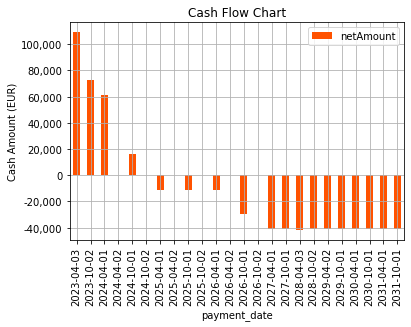

In [ ]:
# Request portfolio cash flows
portfolio_cash_flows = transaction_portfolios_api.get_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=end_date,
    recipe_id_scope=market_data_scope,
    recipe_id_code=disc_recipe_code
)

# Format cash flow response
cash_flows = cash_flow_response_to_df(portfolio_cash_flows, True)

# Plot net cash flows
ax = cash_flows.plot.bar(y=['netAmount'], color = ['#ff5200'])
plt.title('Cash Flow Chart')
plt.ylabel('Cash Amount (EUR)')
display(cash_flows)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid()
plt.show()

### 6.3 Overriding Cash Flows

In addition to running validations through the internal pricer, LUSID is also capable of storing data coming in from external systems. All valuations relating to the swap can be ingested externally and stored giving users a rigid data model accessible via API.

In the example below we are going to override the cash flows of the swap based on some override figures. We will then see that we can adjust the recipe used in retrieving the cash flows to use these overrides.

Using the new recipe would allow a user to query portfolio cash flow projections for a book of derivatives using external projections rather than the LUSID ones seen before.

In [ ]:
# Create some cash flow override data
external_cash_flows = pd.read_csv("data/external_instrument_cash_flows.csv")
external_cash_flows["Dates"] = pd.to_datetime(external_cash_flows["Dates"])
add_utc_to_df(external_cash_flows)
external_cash_flows.head(10)

,Dates,Receive,Pay
0,2022-07-29 00:00:00+00:00,100000,"25,000.0000"
1,2023-01-31 00:00:00+00:00,100000,"25,000.0000"
2,2023-07-31 00:00:00+00:00,100000,"-100,100.0000"
3,2024-01-31 00:00:00+00:00,100000,"-100,200.1000"
4,2024-07-31 00:00:00+00:00,100000,"-100,300.3001"
5,2025-01-31 00:00:00+00:00,100000,"-100,400.6004"
6,2025-07-31 00:00:00+00:00,100000,"-100,501.0010"
7,2026-01-30 00:00:00+00:00,100000,"-100,601.5020"
8,2026-07-31 00:00:00+00:00,100000,"-100,702.1035"
9,2027-01-29 00:00:00+00:00,100000,"-100,802.8056"


Use the _StructuredResultDataApi_ to store the cash flows in LUSID. This will involve creating a _CashFlowValueSet_, as well as a structured result data ID which we will refer back to in the configuration recipe.

In [ ]:
document_scope = "CashOverride"
document_code ="EurOisIrs"

# Persist pay amounts
pay_leg_flows = [
    lm.CashFlowValue(
        result_value_type="CashFlowValue",
        payment_amount=row["Pay"],
        payment_date=row["Dates"],
        payment_ccy=instrument_ccy,
        cash_flow_lineage= lm.CashFlowLineage(
            cash_flow_type="Coupon",
            pay_receive="Pay"
        )
    ) for i, row in external_cash_flows.iterrows()
    ]


# Persist receive amounts
rec_leg_flows = [
    lm.CashFlowValue(
        result_value_type="CashFlowValue",
        payment_amount=row["Receive"]/notional, # Unitize amount
        payment_date=row["Dates"],
        payment_ccy=instrument_ccy,
        cash_flow_lineage= lm.CashFlowLineage(
            cash_flow_type="Coupon",
            pay_receive="Receive"
        )
    ) for i, row in external_cash_flows.iterrows()
    ]

# Create external cash flow set from pays and receives
external_cash_flow_set = lm.CashFlowValueSet(
    cashflows=pay_leg_flows + rec_leg_flows,
    result_value_type="CashFlowValueSet"
)

# Create a structured document ID
struct_result_data_id = lm.StructuredResultDataId(
    source = 'Client',
    code=document_code,
    effective_at= effective_at,
    result_type = "UnitResult/Analytic")

upsert_result_values_data_request = lm.UpsertResultValuesDataRequest(
    document_id=struct_result_data_id,
    key={
        f"UnitResult/LusidInstrumentId":f"{vanilla_luid}" # Instrument to which document resolves
    },
    data_address="UnitResult/Valuation/Cashflows",  # Valuation result to override
    result_value=external_cash_flow_set
    )

response = structured_result_data_api.upsert_result_value(
    scope = document_scope,
    request_body={
        "CashFlows":upsert_result_values_data_request
    }
)

if len(response.failed) == 0:
    print(f"Cash Flow set has successfully been loaded into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)

Cash Flow set has successfully been loaded into LUSID


In this example we will only override the results of the _"Discounting"_ model:

In [ ]:
# Create new recipe scope for overrides and result data 'ResultDataKeyRule'
custom_cash_recipe_scope = "CashOverride"
result_data_rules=[
            lm.ResultDataKeyRule(
                result_key_rule_type='ResultDataKeyRule',
                supplier= "Client",
                data_scope = document_scope,
                document_code = document_code,
                resource_key= "UnitResult/Valuation/Cashflows",
                document_result_type= "UnitResult/Analytic",
                quote_interval= "5D"
                )
            ]

# Add result_data_rules to the Discounting configuration recipe and update scope
disc_configuration_recipe.pricing.result_data_rules = result_data_rules
disc_configuration_recipe.scope = custom_cash_recipe_scope

# Upsert object under new scope
response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=disc_configuration_recipe
    )
)

print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2022-12-09 16:15:55.595025+00:00.


With the cash flows stored in LUSID against the instrument, we can now see that querying the portfolio cash flows come back with the external data.

In [ ]:
# Request portfolio cash flows
external_cash_flow_response = transaction_portfolios_api.get_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=end_date,
    recipe_id_scope=custom_cash_recipe_scope,
    recipe_id_code=disc_recipe_code
)

cash_flows = cash_flow_response_to_df(external_cash_flow_response)
display(cash_flows)

,payAmount,receiveAmount,netAmount
payment_date,,,
2023-01-31,"-25,000.0000",0.0500,"-24,999.9500"
2023-07-31,"100,100.0000",0.0500,"100,100.0500"
2023-10-02,"-7,120.3181","7,956.7800",836.4619
2024-01-31,"100,200.1000",0.0500,"100,200.1500"
2024-04-02,"-8,147.9959","8,147.9959",0.0000
2024-07-31,"100,300.3001",0.0500,"100,300.3501"
2024-10-02,"-17,540.5186","17,540.5186",0.0000
2025-01-31,"100,400.6004",0.0500,"100,400.6504"
2025-04-02,"-22,996.1651","22,996.1651",0.0000


### 6.4 Querying Curves

Similarly, if we inspect the cash flows response, we will notice that we get back information relating back to the discount curve as well as the forward rates that will be used internally for a  valuation in the _'Discounting'_ model. These are plotted below for some visual aid on the curves used internally by the pricer.

,Forward Rate,Discount Factor,Year Fraction,Cumulative Year Fraction,Discount Rate
2023-04-03,-0.0016,0.9999,0.5056,0.5056,0.0002
2023-10-02,0.0035,0.9969,1.0317,1.5373,0.0020
2024-04-01,0.0078,0.9930,0.5056,2.0429,0.0035
2024-10-01,0.0167,0.9846,0.5083,2.5512,0.0061
2025-04-01,0.0223,0.9736,0.5056,3.0567,0.0087
2025-10-01,0.0223,0.9627,0.5083,3.5651,0.0107
2026-04-01,0.0223,0.9520,0.5056,4.0706,0.0121
2026-10-01,0.0259,0.9396,0.5083,4.5790,0.0136
2027-04-01,0.0281,0.9265,0.5056,5.0845,0.0150
2027-10-01,0.0281,0.9134,0.5083,5.5929,0.0162


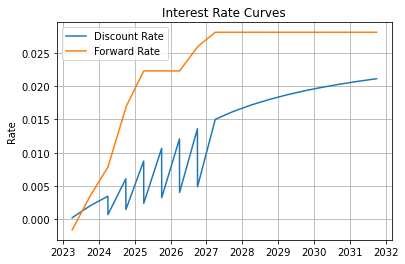

In [ ]:
# Extract discount/forward curve information from cash flow response
curve_data = {
    element.payment_date.date(): {
        "Forward Rate": float(element.diagnostics.get("ForwardRate")),
        "Discount Factor": float(element.diagnostics.get("PaymentDateDiscountFactor")),
        "Year Fraction": float(element.diagnostics.get("DayCountFraction"))
    } for element in portfolio_cash_flows.values if element.diagnostics["PayReceive"] == "Pay"
}

# Create curve table
curve_df = pd.DataFrame.from_dict(curve_data, orient="index")
curve_df["Cumulative Year Fraction"] = curve_df["Year Fraction"].cumsum()
curve_df["Discount Rate"] = curve_df.apply(lambda x: -np.log(getattr(x, "Discount Factor"))/getattr(x, "Cumulative Year Fraction"), axis=1)
display(curve_df)

# Plot curves
curve_df.plot.line(y=["Discount Rate", "Forward Rate"])
plt.title('Interest Rate Curves')
plt.ylabel('Rate')
plt.grid()
plt.show()

## 7. Instrument Lifecycle

LUSID can handle instrument life cycle events in the form of transactions that alter the current position against the instrument. A user has the option to either ingest these events from an external system as part of their regular transaction and corporate action processing, or use LUSID's projected flows that can be derived from an instrument's economic definition.

For instruments where LUSID has a full understanding of its economic definition, the system will have knowledge of upcoming events and can be used directly to synthesize these. For example, where the upcoming cash flows are known for the latest reset period, the GetUpsertablePortfolioCashFlows API can be queried for these. In such instances LUSID will return a readily upsertable  transaction request, that could also be used for automated lifecycle handling.

### 7.1 Configuring Transactions

By default, when returning the cash flow events via the upsertable cash flows API it will return a transaction type of `CashFlow`, which will simply increment the cash position by the amount returned by the projection. However, using LUSID's transaction configuration, it is possible to create other types that the API will select instead of a simple cash flow.

Below, we show how to add a new transaction type within the domain's transaction config and associate it with a special system property under the key `TransactionConfiguration/default/CashFlowType`.

As we can see, we are setting the `CashFlowType` property to the value of `Coupon` on the config, which is associated with IRS instruments internally within LUSID. The full list of cash flow types is documented [here](https://support.lusid.com/knowledgebase/article/KA-01744/#transaction-type). Once this has been configured, it will override the response from `GetUpsertableCashFlows` to the new transaction type.

Notice that the transaction below sets another movement to the cash flow which is of type `Carry`, which will help us in breaking down where the instrument's P&L is coming from later in the A2B report. More detail on this can be found under the following article linked [here](https://support.lusid.com/knowledgebase/article/KA-01797/en-us).

In [ ]:
# Before adding a new transaction type, we need side definitions in our non-default transaction type scope. So fetch the default side definitions and set them in the transaction type scope
default_side_definitions = api_factory.build(lusid.api.TransactionConfigurationApi).list_side_definitions()

def mapSide(side_definition):
    return {"side": side_definition.side, "sideRequest": lusid.models.SideDefinitionRequest(security = side_definition.security, currency = side_definition.currency, rate = side_definition.rate, units = side_definition.units, amount = side_definition.amount, notional_amount= side_definition.notional_amount)}

set_side_definitions_request = [mapSide(side_definition) for side_definition in default_side_definitions.values]
pprint.pprint(set_side_definitions_request)
api_factory.build(lusid.api.TransactionConfigurationApi).set_side_definitions(set_side_definitions_request, scope = transaction_type_scope)

# Create a transaction config request
new_transaction_config = lm.TransactionTypeRequest(
    aliases=[
        lm.TransactionTypeAlias(
            type="Coupon",
            description="A coupon or cash flow from term instrument with a carry movement.",
            transaction_class="default",
            transaction_roles="AllRoles",
        )
    ],
    movements=[
        # Carry movement to correctly attribute P&L
        lm.TransactionTypeMovement(
            movement_types="Carry",
            side="Side1",
            direction=1,
            properties={},
            mappings=[]
        ),
        # CashCommitment movement to increment cash by coupon amount
        lm.TransactionTypeMovement(
            movement_types="CashCommitment",
            side="Side2",
            direction=1,
            properties={},
            mappings=[],
        ),
    ],
    # Special internal property that associates the instrument to this movement
    properties={
                "TransactionConfiguration/default/CashFlowType": lm.PerpetualProperty(
                    key="TransactionConfiguration/default/CashFlowType",
                    value=lm.PropertyValue(
                        label_value="Coupon"
                    )
                )
            }
)

In [ ]:
 # Upload the transaction type
new_txn_config = api_factory.build(lusid.api.TransactionConfigurationApi).set_transaction_type(
    source="default",
    type="Coupon",
    transaction_type_request=new_transaction_config,
    scope=transaction_type_scope
)

# Call LUSID to update the transaction type scope of your portfolio 
patch_document = [
    {
        "value": transaction_type_scope,
        "path": "/transactiontypescope",
        "op": "add"
    }
]
patch_response = api_factory.build(lusid.api.TransactionPortfoliosApi).patch_portfolio_details(
    scope=portfolio_scope,
    code=portfolio_code,
    operation=patch_document)
prettyprint.portfolio_response(patch_response)

### 7.2 Cash Handling on Payment Date

Below we will request the upsertable portfolio cash flows for the upcoming 400 days.

In [ ]:
# Set the life cycle end date from our original effective date
life_cycle_end_date = effective_at + timedelta(days=400)

upsertable_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=life_cycle_end_date,
    recipe_id_scope=market_data_scope,
    recipe_id_code=disc_recipe_code
)

lusid_response_to_data_frame(upsertable_cash_flows)

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,...,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/Finbourne-Examples/Strategy.key,properties.Transaction/Finbourne-Examples/Strategy.value.label_value,properties.Transaction/default/ParentLuid.key,properties.Transaction/default/ParentLuid.value.label_value,source,entry_date_time,transaction_status
0,TXN001-LUID_0004L4ZO-20230403-Coupon-EUR-Receive,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-04-03 00:00:00+00:00,2023-04-03 00:00:00+00:00,"60,666.6667",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Hedge,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
1,TXN001-LUID_0004L4ZO-20231002-Coupon-EUR-Receive,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"60,666.6667",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Hedge,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
2,TXN001-LUID_0004L4ZO-20230403-Coupon-EUR-Pay,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-04-03 00:00:00+00:00,2023-04-03 00:00:00+00:00,"4,878.2192",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Hedge,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
3,TXN001-LUID_0004L4ZO-20231002-Coupon-EUR-Pay,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"-17,782.7092",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Hedge,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
4,TXN002-LUID_0004L4ZO-20230403-Coupon-EUR-Receive,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-04-03 00:00:00+00:00,2023-04-03 00:00:00+00:00,"40,444.4444",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
5,TXN002-LUID_0004L4ZO-20231002-Coupon-EUR-Receive,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"40,444.4444",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
6,TXN002-LUID_0004L4ZO-20230403-Coupon-EUR-Pay,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-04-03 00:00:00+00:00,2023-04-03 00:00:00+00:00,"3,252.1462",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
7,TXN002-LUID_0004L4ZO-20231002-Coupon-EUR-Pay,ReceiveCoupon,LUID_0004L4ZO,TestSwapNotebook,LUID_0004L4ZO,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"-11,855.1395",1.0000,Price,...,EUR,1.0000,EUR,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZO,default,0001-01-01 00:00:00+00:00,Active
8,TXN003-LUID_0004L4ZP-20231002-Coupon-GBP-Pay,ReceiveCoupon,LUID_0004L4ZP,TestSwapNotebook,LUID_0004L4ZP,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"-7,120.3181",1.0000,Price,...,GBP,1.0000,GBP,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZP,default,0001-01-01 00:00:00+00:00,Active
9,TXN003-LUID_0004L4ZP-20231002-Coupon-USD-Receive,ReceiveCoupon,LUID_0004L4ZP,TestSwapNotebook,LUID_0004L4ZP,2023-10-02 00:00:00+00:00,2023-10-02 00:00:00+00:00,"7,956.7800",1.0000,Price,...,USD,1.0000,USD,Transaction/Finbourne-Examples/Strategy,Deal,Transaction/default/ParentLuid,LUID_0004L4ZP,default,0001-01-01 00:00:00+00:00,Active


In [ ]:
for element in upsertable_cash_flows.values:
    element.instrument_identifiers = {"Instrument/default/LusidInstrumentId": element.instrument_uid}

# Upsert the transactions
response = transaction_portfolios_api.upsert_transactions(
    scope=portfolio_scope, code=portfolio_code, transaction_request=upsertable_cash_flows.values
)

print(f"Transaction updated for effective time: {response.version.effective_from}.")

Transaction updated for effective time: 2010-01-01 00:00:00+00:00.


We can now check the portfolio for its holdings post the payment event, where we notice that the net amount of cash for the payment period has settled.

Notice that the cash receivable via the previously configured `Coupon` type has been broken down by strategy, retaining the initial allocations.

In [ ]:
# Check holdings post life cycle event
holdings = transaction_portfolios_api.get_holdings(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=life_cycle_end_date
 )

lusid_response_to_data_frame(holdings)

,instrument_scope,instrument_uid,sub_holding_keys.Transaction/Finbourne-Examples/Strategy.key,sub_holding_keys.Transaction/Finbourne-Examples/Strategy.value.label_value,properties.Holding/default/SourcePortfolioId.key,properties.Holding/default/SourcePortfolioId.value.label_value,properties.Holding/default/SourcePortfolioId.effective_from,properties.Holding/default/SourcePortfolioScope.key,properties.Holding/default/SourcePortfolioScope.value.label_value,properties.Holding/default/SourcePortfolioScope.effective_from,holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,cost_portfolio_ccy.currency,currency,holding_type_name
0,TestSwapNotebook,LUID_0004L4ZO,Transaction/Finbourne-Examples/Strategy,Hedge,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,P,0.6000,0.6000,0.0000,EUR,0.0000,EUR,EUR,Position
1,TestSwapNotebook,LUID_0004L4ZO,Transaction/Finbourne-Examples/Strategy,Deal,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,P,0.4000,0.4000,0.0000,EUR,0.0000,EUR,EUR,Position
2,TestSwapNotebook,LUID_0004L4ZP,Transaction/Finbourne-Examples/Strategy,Deal,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,P,1.0000,1.0000,0.0000,USD,0.0000,EUR,USD,Position
3,default,CCY_EUR,Transaction/Finbourne-Examples/Strategy,Hedge,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,B,"108,428.8434","108,428.8434","108,428.8500",EUR,"108,428.8500",EUR,EUR,Balance
4,default,CCY_EUR,Transaction/Finbourne-Examples/Strategy,Deal,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,B,"72,285.8956","72,285.8956","72,285.8900",EUR,"72,285.8900",EUR,EUR,Balance
5,default,CCY_GBP,Transaction/Finbourne-Examples/Strategy,Deal,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,B,"-7,120.3181","-7,120.3181","-7,120.3200",GBP,0.0000,EUR,GBP,Balance
6,default,CCY_USD,Transaction/Finbourne-Examples/Strategy,Deal,Holding/default/SourcePortfolioId,Interest-Rate-Swap-Notebook,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,B,"7,956.7800","7,956.7800","7,956.7800",USD,0.0000,EUR,USD,Balance


## 8. P&L Reporting

Next we are going to run a LUSID A2B report on the portfolio, which will break down the P&L of the position for a given window.

The AtoB report will give a breakdown of each holding's P&L, including the flows (transactions) that have occurred in the selected window. Within the report you will find the following detail:

- **Market Value (Start):** The market value at the start of the window.
- **Market Gain:** Capital Gain, or gain due to asset appreciation based on available market data.
- **Carry:** Interest and dividend accruals where applicable, also known as carry return.
- **Flows:** Any transaction activity occurring in the period (buys, sells, etc.).
- **Market Value (End):** The market value of the security at the end of the window.

In [ ]:
# Request A2B report
a2b = transaction_portfolios_api.get_a2_b_data(
    scope=portfolio_scope,
    code=portfolio_code,
    from_effective_at=effective_at,
    to_effective_at=effective_at + timedelta(days=3),
    recipe_id_scope=market_data_scope,
    recipe_id_code=disc_recipe_code,
    property_keys=["Instrument/default/Name"]
)

As can be seen below, the report includes the total gains and the flows shown for each unique sub-holding. Note, the following table has been filtered down to some core fields.

In [ ]:
# Rename A2B columns in df
rename_cols = {
    "portfolio_id.scope": "Portfolio Scope",
    "portfolio_id.code": "Portfolio Code",
    "holding_type": "Holding Type",
    "instrument_uid": "Instrument ID",
    "Name(default-Properties)": "Instrument Name",
    "start.portfolio_currency.total": "Market Value (Start)",
    "start.portfolio_currency.components.MarketGain": "P&L - Since inception (Start)",
    "start.portfolio_currency.components.AccruedInterest": "Accrued Interest (Start)",
    "gains.portfolio_currency.total":"P&L (Window)",
    "gains.portfolio_currency.components.DeltaMarketGain": "Market Gain (Window)",
    "carry.portfolio_currency.total": "Carry (Window)",
    "end.portfolio_currency.total": "Market Value (End)",
    "end.portfolio_currency.components.MarketGain": "P&L - Since inception (End)",
    "end.portfolio_currency.components.AccruedInterest": "Accrued Interest (End)"
}

# Format and filter A2B
a2b_df = lusid_response_to_data_frame(a2b, rename_properties=True)
col_filters = rename_cols.keys()
a2b_df = a2b_df[col_filters].copy()
a2b_df.rename(columns=rename_cols, inplace=True)
a2b_df

,Portfolio Scope,Portfolio Code,Holding Type,Instrument ID,Instrument Name,Market Value (Start),P&L - Since inception (Start),Accrued Interest (Start),P&L (Window),Market Gain (Window),Carry (Window),Market Value (End),P&L - Since inception (End),Accrued Interest (End)
0,Finbourne-Examples,Interest-Rate-Swap-Notebook,P,LUID_0004L4ZO,EUROIS.REC.10Y,"-64,517.9200","-81,110.7000","16,592.7800",-827.7100,-827.7100,858.1900,"-64,487.4400","-81,938.4100","17,450.9700"
1,Finbourne-Examples,Interest-Rate-Swap-Notebook,P,LUID_0004L4ZO,EUROIS.REC.10Y,"-96,776.8800","-121,666.0500","24,889.1700","-1,241.5600","-1,241.5600","1,287.2800","-96,731.1600","-122,907.6100","26,176.4500"
2,Finbourne-Examples,Interest-Rate-Swap-Notebook,P,LUID_0004L4ZP,GBPUSD.XCCY.4Y,"-23,286.0400","-23,926.0500",640.0100,-28.1400,-28.1400,45.7400,"-23,268.4400","-23,954.1900",685.7500


Similarly, we can also group by instrument to see the P&L measures at the swap level by simply grouping as shown below using the instrument ID.

In [ ]:
a2b_df.groupby("Instrument ID").sum()


,Market Value (Start),P&L - Since inception (Start),Accrued Interest (Start),P&L (Window),Market Gain (Window),Carry (Window),Market Value (End),P&L - Since inception (End),Accrued Interest (End)
Instrument ID,,,,,,,,,
LUID_0004L4ZO,"-161,294.8000","-202,776.7500","41,481.9500","-2,069.2700","-2,069.2700","2,145.4700","-161,218.6000","-204,846.0200","43,627.4200"
LUID_0004L4ZP,"-23,286.0400","-23,926.0500",640.0100,-28.1400,-28.1400,45.7400,"-23,268.4400","-23,954.1900",685.7500


In [ ]:
# CLEAN UP - Delete Portfolio
response = portfolios_api.delete_portfolio(
    scope=portfolio_scope,
    code=portfolio_code
)
print(f"Successfully deleted portfolio with scope: {portfolio_scope} and code: {portfolio_code} ")